In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:

# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [3]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)



In [28]:
def compute_sign_changes(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons).
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,).
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron.
    """
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)
    
    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations, exclude last reactivation for shape match
    reactivation_sign_changes = trial_sign_changes[trial_r] 

    return reactivation_sign_changes

def clean_and_prepare_data(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression ensuring correct trial-to-trial differences.
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons).
    - mean_activity_cs: Trial-level activity (shape: trials x neurons).
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,).
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity 
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]

        # Compute targets for this neuron 
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        
        # Append predictors (features) for this neuron
        X_list.append(X_neuron)
        
        # The target is calculated for each neuron for every reactivation
        y_list.append(y_neuron)
    
    # Stack all neurons' features (each reactivation has a set of features across neurons)
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, neurons)
    
    # Combine all target values for reactivations and neurons
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, neurons) -> sign change for each neuron

    # Only 0s and 1s
    y_all = np.where(y_all == -1, 0, 1)
    
    # Print to verify correct shapes
    print(f"x_all and y_all", X_all.shape, y_all.shape)  # Make sure X_all and y_all align
    
    return X_all, y_all

X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)


# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))

print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))


x_all and y_all (139, 3124) (139, 3124)
x_all and y_all (111, 3124) (111, 3124)
(250, 3124) (250, 3124)
Processed Targets for CS_1:
{0: 216563, 1: 217673}

Processed Targets for CS_2:
{0: 173997, 1: 172767}


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve
import shap
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

# (Optional) if you want to store predictions across folds:
all_y_test = []
all_y_pred = []

fold_index = 1
for train_idx, test_idx in kf.split(X_all):
    print(f"\n=== Fold {fold_index} ===")
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    base_model = LogisticRegression(max_iter=1000, random_state=42)
    model_cv = MultiOutputClassifier(base_model)
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    # Flatten for micro-averaged metrics
    y_test_flat = y_test.ravel()
    y_pred_flat = y_pred.ravel()

    acc = accuracy_score(y_test_flat, y_pred_flat)
    pre = precision_score(y_test_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_test_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_test_flat, y_pred_flat, zero_division=0)

    all_accuracies.append(acc)
    all_precisions.append(pre)
    all_recalls.append(rec)
    all_f1s.append(f1)
    
    # Print fold-specific metrics
    print(f"Fold Accuracy:  {acc:.3f}")
    print(f"Fold Precision: {pre:.3f}")
    print(f"Fold Recall:    {rec:.3f}")
    print(f"Fold F1:        {f1:.3f}")

    # Optionally store predictions
    all_y_test.append(y_test)
    all_y_pred.append(y_pred)

    fold_index += 1

# Aggregate CV results
mean_acc = np.mean(all_accuracies)
std_acc  = np.std(all_accuracies)

mean_pre = np.mean(all_precisions)
mean_rec = np.mean(all_recalls)
mean_f1  = np.mean(all_f1s)

print("\n=== Cross-Validation Summary ===")
print(f"Accuracy:  {mean_acc:.3f} ± {std_acc:.3f}")
print(f"Precision: {mean_pre:.3f}")
print(f"Recall:    {mean_rec:.3f}")
print(f"F1-score:  {mean_f1:.3f}")



=== Fold 1 ===
Fold Accuracy:  0.839
Fold Precision: 0.849
Fold Recall:    0.838
Fold F1:        0.843

=== Fold 2 ===
Fold Accuracy:  0.864
Fold Precision: 0.846
Fold Recall:    0.877
Fold F1:        0.861

=== Fold 3 ===
Fold Accuracy:  0.879
Fold Precision: 0.877
Fold Recall:    0.880
Fold F1:        0.879

=== Fold 4 ===
Fold Accuracy:  0.841
Fold Precision: 0.836
Fold Recall:    0.836
Fold F1:        0.836

=== Fold 5 ===
Fold Accuracy:  0.865
Fold Precision: 0.869
Fold Recall:    0.871
Fold F1:        0.870

=== Cross-Validation Summary ===
Accuracy:  0.858 ± 0.015
Precision: 0.855
Recall:    0.860
F1-score:  0.858


In [33]:
# Concatenate test sets and predictions from all folds
y_test_all_folds = np.concatenate(all_y_test, axis=0)
y_pred_all_folds = np.concatenate(all_y_pred, axis=0)

y_test_flat_all = y_test_all_folds.ravel()
y_pred_flat_all = y_pred_all_folds.ravel()

overall_conf_mat = confusion_matrix(y_test_flat_all, y_pred_flat_all)
print("\n=== Overall Confusion Matrix (All Folds, Micro) ===")
print(overall_conf_mat)

print("\n=== Overall Classification Report (All Folds, Micro) ===")
print(classification_report(y_test_flat_all, y_pred_flat_all, target_names=["0 (Decrease)", "1 (Increase)"]))

overall_acc  = accuracy_score(y_test_flat_all, y_pred_flat_all)
overall_prec = precision_score(y_test_flat_all, y_pred_flat_all, zero_division=0)
overall_rec  = recall_score(y_test_flat_all, y_pred_flat_all, zero_division=0)
overall_f1   = f1_score(y_test_flat_all, y_pred_flat_all, zero_division=0)

print("=== Overall (Micro) Metrics (All Folds) ===")
print(f"Accuracy:  {overall_acc:.3f}")
print(f"Precision: {overall_prec:.3f}")
print(f"Recall:    {overall_rec:.3f}")
print(f"F1-Score:  {overall_f1:.3f}")



=== Overall Confusion Matrix (All Folds, Micro) ===
[[333825  56735]
 [ 54511 335929]]

=== Overall Classification Report (All Folds, Micro) ===
              precision    recall  f1-score   support

0 (Decrease)       0.86      0.85      0.86    390560
1 (Increase)       0.86      0.86      0.86    390440

    accuracy                           0.86    781000
   macro avg       0.86      0.86      0.86    781000
weighted avg       0.86      0.86      0.86    781000

=== Overall (Micro) Metrics (All Folds) ===
Accuracy:  0.858
Precision: 0.856
Recall:    0.860
F1-Score:  0.858


Coefficients shape: (3124, 3124)
Coefficients for neuron 0:
 [ 0.00289962 -0.00171224  0.01380441 ...  0.00171474 -0.02345241
 -0.01717993]

Mean Coefficients Across Neurons: [-0.00882993 -0.00485018 -0.00809112 ... -0.00993778  0.00411638
  0.01047174]
Std Deviation of Coefficients Across Neurons: [0.01961533 0.0166356  0.0221621  ... 0.05024531 0.04201244 0.03523382]


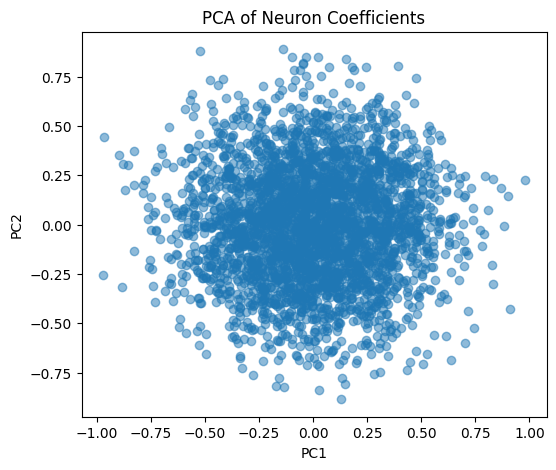

In [34]:
coefficients = []
for i, est in enumerate(model_cv.estimators_):
    # est.coef_ shape: (1, n_features) for binary logistic regression
    coefficients.append(est.coef_[0])

coefficients = np.array(coefficients)  # shape: (n_neurons, n_features)

print("Coefficients shape:", coefficients.shape)
print("Coefficients for neuron 0:\n", coefficients[0])

mean_coeffs = np.mean(coefficients, axis=0)
std_coeffs = np.std(coefficients, axis=0)

print("\nMean Coefficients Across Neurons:", mean_coeffs)
print("Std Deviation of Coefficients Across Neurons:", std_coeffs)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coeffs_2d = pca.fit_transform(coefficients)  # shape: (n_neurons, 2)

plt.figure(figsize=(6, 5))
plt.scatter(coeffs_2d[:,0], coeffs_2d[:,1], alpha=0.5)
plt.title("PCA of Neuron Coefficients")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



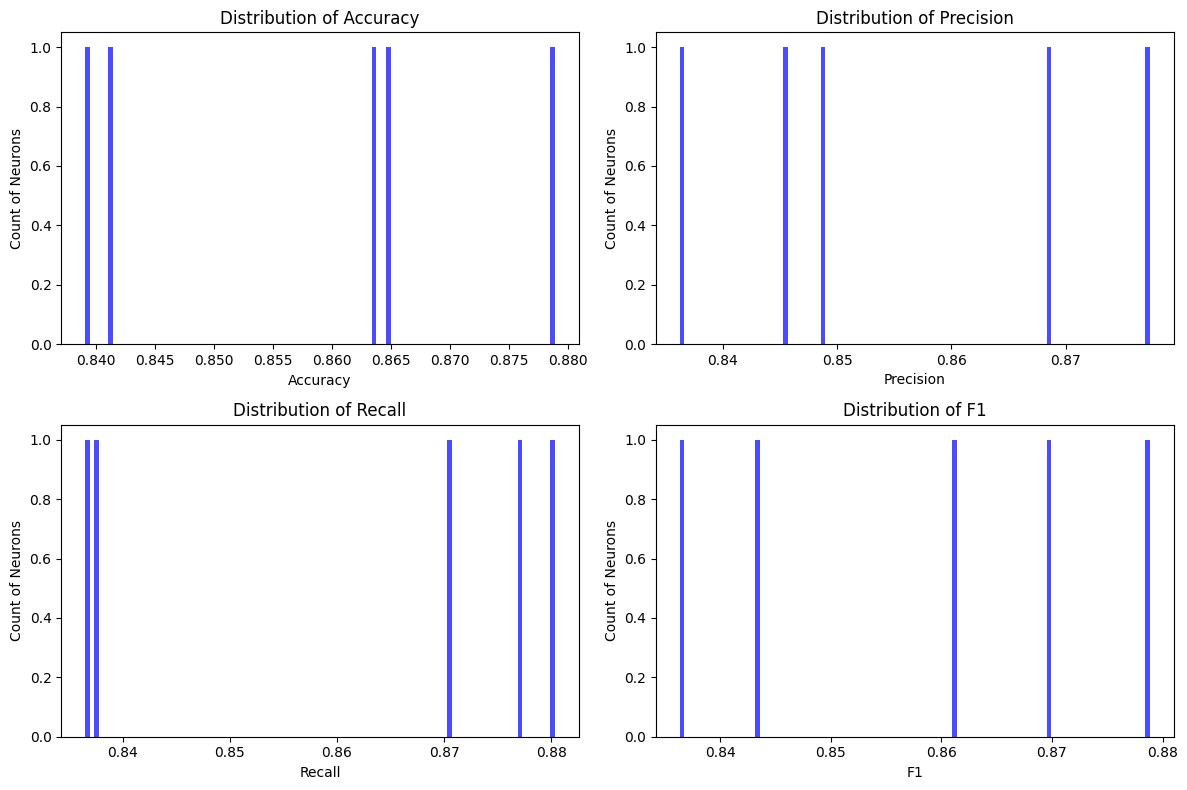

In [37]:
# accuracy, precision, recall, f1 are lists (per neuron)
metrics_dict = {
    "Accuracy": all_accuracies,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1": all_f1s
}

plt.figure(figsize=(12, 8))
for i, (metric_name, values) in enumerate(metrics_dict.items()):
    plt.subplot(2, 2, i+1)
    plt.hist(values, bins=100, alpha=0.7, color='b')
    plt.title(f"Distribution of {metric_name}")
    plt.xlabel(metric_name)
    plt.ylabel("Count of Neurons")

plt.tight_layout()
plt.show()
